In [2]:
using PyPlot

# Evaluating the 2D Ising model partition function

## Labelling configurations

To sum over all $2^N$ configurations of $N$ spins we need to somehow enumerate them. One way of assigning integers to configurations is simply to choose an ordering of the spins, which immediately gives us a binary integer.

We can slightly abuse Julia's BitArray for this purpose. BitArrays are arrays of bits stored in memory as a series of 64-bit unsigned integers, as we can confirm by looking at the source https://github.com/JuliaLang/julia/blob/v0.6.0/base/bitarray.jl. If we restrict ourselves to $N \le 64$ we can enumerate configurations by incrementing the integer used as storage for the BitArray.

In [3]:
ba = BitArray(8,8)

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

The integers are stored in a field called "chunks". Since we asked for an array with 64 bits, only one chunk is used.

In [4]:
size(ba.chunks)

(1,)

It has the initial value 0.

In [5]:
ba.chunks[1]

0x0000000000000000

Let's print out the first few configurations!

In [6]:
ba.chunks[1] = 1
ba

8×8 BitArray{2}:
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [7]:
ba.chunks[1] = 2
ba

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [8]:
ba.chunks[1] = 3
ba

8×8 BitArray{2}:
  true  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [9]:
ba.chunks[1] = 4
ba

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

## Summing over configurations

To evaluate the partition function exactly we must sum over all configurations.
There are quite a few configurations of an 8x8 array of spins.

In [10]:
2.0^64

1.8446744073709552e19

We will need to work with fewer if we want our sums to complete in a reasonable time. How about 25?

In [11]:
2^(5^2)

33554432

Much better. 

In [12]:
ba_sm = BitArray(5,5)

5×5 BitArray{2}:
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false

In [13]:
ba_sm.chunks[1] = 2^25-1

33554431

In [14]:
ba_sm

5×5 BitArray{2}:
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true

## Computing weights

Now, how to evaluate the weight of a configuration? Let's write a funcion that takes a configuration in the form of a BitArray and returns the weight.

In [15]:
spin(b::Bool) = Float64(2 * b - 1)

spin (generic function with 1 method)

In [59]:
@time spin(true)

  0.000012 seconds (5 allocations: 176 bytes)


1.0

In [130]:
@time spin(false)

  0.000005 seconds (5 allocations: 176 bytes)


-1.0

In [150]:
function ising_weight_2D_PBC(c::BitArray{2}, h::Float64, Jx::Float64, Jy::Float64, β::Float64)::Float64
    Ly,Lx = size(c)
    
    en = 0.0
    @inbounds @fastmath for k in 1:Lx, j in 1:Ly
        s = spin(c[j,k])
        en -= h * s
        en -= Jx * s * spin(c[j,mod1(k+1, Lx)])
        en -= Jy * s * spin(c[mod1(j+1, Ly),k])
    end
    
    exp(-en * β)
end

ising_weight_2D_PBC (generic function with 1 method)

Let's benchmark this. Run it once first to get it compiled.

In [135]:
ising_weight_2D_PBC(ba_sm, 1.0, 1.0, 1.0, 1/2.269);

Now time it.

In [137]:
@time ising_weight_2D_PBC(ba_sm, 1.0, 1.0, 1.0, 1/2.269)

  0.000012 seconds (6 allocations: 192 bytes)


2.266003258686664e14

In [142]:
let b = bitrand(5,6)
    @time ising_weight_2D_PBC(b, 1.0, 1.0, 1.0, 1/2.269)
end

  0.000011 seconds (6 allocations: 192 bytes)


858040.2994371965

There is a fixed, small number of allocations, so performance should be good.

## Computing the partition function
Let's try evaluating $Z(h, J_x, J_y)$.

In [143]:
function ising_Z_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = BitArray(Ly,Lx)
    Z = 0.0
    for j in 0:2^N-1
        c.chunks[1] = j
        Z += ising_weight_2D_PBC(c, h, Jx, Jy, β)
    end
    
    Z
end

ising_Z_2D_PBC (generic function with 1 method)

In [146]:
@time ising_Z_2D_PBC(4,4,0.0,1.0,1.0,1/2.269)

  0.047540 seconds (9 allocations: 368 bytes)


2.7157159208264876e7

$20$ spins is a practical upper-limit for a fairly quick computation.

In [148]:
@time ising_Z_2D_PBC(5,4,0.0,1.0,1.0,1/2.269)

  0.741399 seconds (9 allocations: 368 bytes)


1.960109019758828e9

## Evaluation of some thermodynamic variables

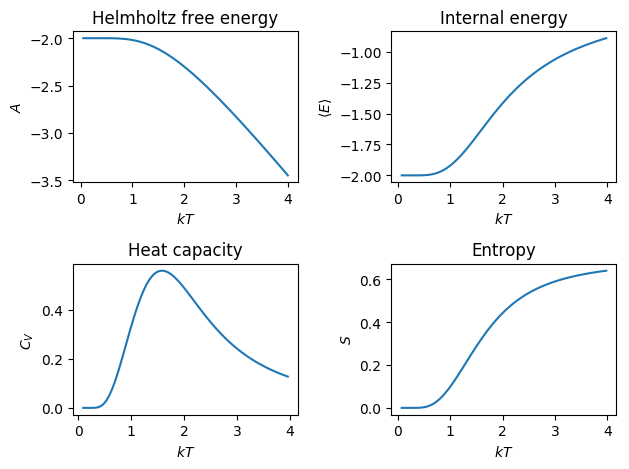

  3.998970 seconds (7.33 k allocations: 416.933 KiB)


In [149]:
let Lx = 4, Ly = 4, h = 0.0, Jx = 1.0, Jy = 1.0, kTs = linspace(0.01, 4.0, 100)
    N = Lx * Ly
    βs = 1./kTs
    @time logZs = Float64[log(ising_Z_2D_PBC(Lx,Ly,h,Jx,Jy,β)) for β in βs]
    As = -kTs .* logZs ./ N
    
    kTmids = kTs[1:end-1] + diff(kTs) ./ 2
    βmids = βs[1:end-1] + diff(βs) ./ 2
    
    subplot(222)
    title("Internal energy")
    ens = -diff(logZs) ./ diff(βs) ./ N
    plot(kTmids, ens, "-")
    xlabel(L"kT")
    ylabel(L"\langle E \rangle")
    
    subplot(223)
    title("Heat capacity")
    cs =  diff(ens) ./ diff(kTmids)
    plot(kTs[2:end-1], cs, "-")
    xlabel(L"kT")
    ylabel(L"C_V")
    
    subplot(224)
    title("Entropy")
    S = (ens .- (As[1:end-1] + As[2:end])./2) .* βmids
    plot(kTmids, S, "-")
    xlabel(L"kT")
    ylabel(L"S")
    
    subplot(221)
    title("Helmholtz free energy")
    plot(kTs, As, "-")
    #plot(kTmids, ens .- kTmids .* S, "-")
    xlabel(L"kT")
    ylabel(L"A")
    
    tight_layout()
end

## Evaluation of expectation values

Here we will compute the magnetization. First define the magnetization of a configuration:

In [52]:
function ising_mag_2D_PBC(c::BitArray{2})::Float64
    Ly,Lx = size(c)
    N = Lx * Ly
    Nup = countnz(c)
    
    (2Nup - N) / N
end

ising_mag_2D_PBC (generic function with 1 method)

We can use this, together with the weight function, to compute the expectation value of the magnetization:

In [54]:
function ising_m_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = BitArray(Ly,Lx)
    Z = 0.0
    M = 0.0
    for j in 0:2^N-1
        c.chunks[1] = j
        w = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        m = ising_mag_2D_PBC(c)
        M += w * m
        Z += w
    end
    
    M / Z
end

ising_m_2D_PBC (generic function with 1 method)

Plot as a function of the external field $h$.

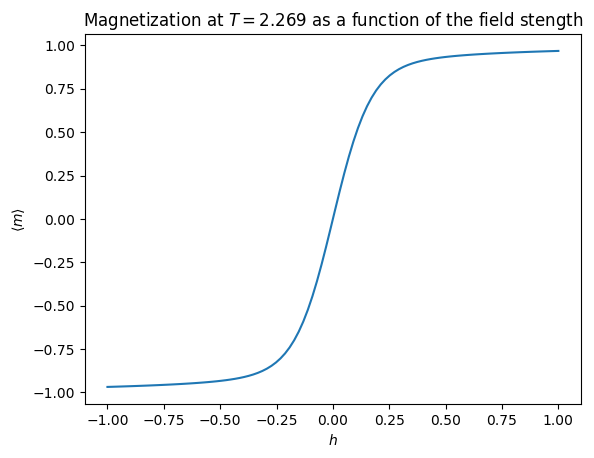

  4.031750 seconds (8.70 k allocations: 469.629 KiB)


PyObject <matplotlib.text.Text object at 0x7f0253f1d7b8>

In [99]:
let Lx = 4, Ly = 4, T = 2.269, Jx = 1.0, Jy = 1.0, hs = linspace(-1.0, 1.0, 100)
    N = Lx * Ly
    @time ms = Float64[ising_m_2D_PBC(Lx,Ly,h,Jx,Jy,1/T) for h in hs]
    plot(hs, ms)
    xlabel(L"h")
    ylabel(L"\langle m \rangle")
    title("Magnetization at \$T=$(T)\$ as a function of the field stength")
end

Plot as a function of the temperature $T$.

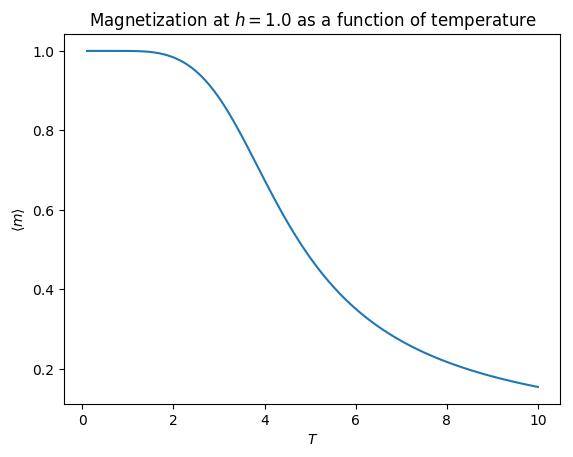

  4.153028 seconds (8.70 k allocations: 469.365 KiB)


PyObject <matplotlib.text.Text object at 0x7f024fc395f8>

In [100]:
let Lx = 4, Ly = 4, h = 1.00, Jx = 1.0, Jy = 1.0, kTs = linspace(0.1, 10.0, 100)
    N = Lx * Ly
    @time ms = Float64[ising_m_2D_PBC(Lx,Ly,h,Jx,Jy,1/kT) for kT in kTs]
    plot(kTs, ms)
    title("\$ h = $h \$")
    xlabel(L"T")
    ylabel(L"\langle m \rangle")
    title("Magnetization at \$h=$(h)\$ as a function of temperature")
end

## Probability distribution

We can also compute the probability distribution, the density of states, and other interesting quantities. Let's define a function that returns the probability of each configuration, together with the magnetization and the value of Z.

In [101]:
function ising_pd_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = BitArray(Ly,Lx)
    Ws = zeros(2^N)
    Ms = zeros(2^N)
    for j in 0:2^N-1
        c.chunks[1] = j
        W = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        M = ising_mag_2D_PBC(c)
        Ws[j+1] = W
        Ms[j+1] = M
    end
    Z = sum(Ws)
    
    P = Ws ./ Z #normalize the weights to probabilities
    
    P, Ms, Z
end

ising_pd_2D_PBC (generic function with 1 method)

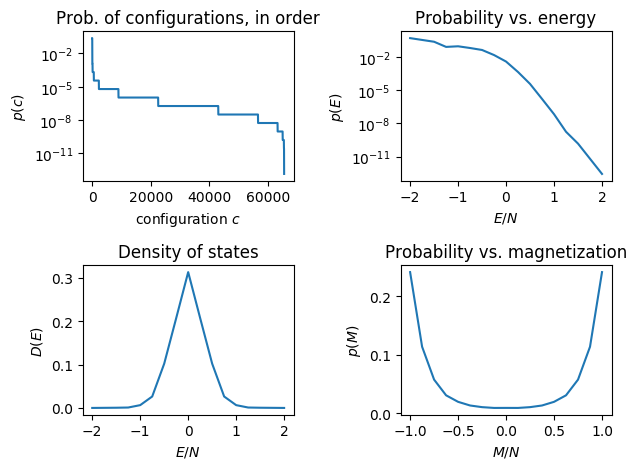

  0.040599 seconds (10 allocations: 1.500 MiB)
sum(P) = 0.9999999999999971


In [153]:
let Lx = 4, Ly = 4, T = 2.269, Jx = 1.0, Jy = 1.0, h = 0.0
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,h,Jx,Jy,1/T)
    
    #Sort the configurations by probability
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T
    
    subplot(221)
    plot(P)
    xlabel(L"configuration $c$")
    ylabel(L"p(c)")
    yscale("log")
    title("Prob. of configurations, in order")
    
    Es_unique = sort(unique(Es))
    
    subplot(222)
    PE = zeros(length(Es_unique))
    for j in 1:length(Es_unique)
        PE[j] = sum(P[Es .== Es_unique[j]])
    end
    plot(Es_unique/N, PE, "-")
    xlabel(L"E/N")
    ylabel(L"p(E)")
    yscale("log")
    title("Probability vs. energy")
    
    subplot(223)
    D = zeros(length(Es_unique))
    for j in 1:length(Es_unique)
        D[j] = countnz(Es .== Es_unique[j]) / length(Es)
    end
    plot(Es_unique / N, D)
    xlabel(L"E/N")
    ylabel(L"D(E)")
    title("Density of states")
    
    subplot(224)
    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        PM[j] = sum(P[Ms .== Ms_unique[j]])
    end
    plot(Ms_unique, PM)
    xlabel(L"M/N")
    ylabel(L"p(M)")
    #yscale("log")
    title("Probability vs. magnetization")
    
    tight_layout()
end